<a href="https://colab.research.google.com/github/ChloeZhou1997/BreastCancerCNN/blob/main/Breast_Cancer_Detection_Project_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prep

1. connect to google drive where data are stored
2. install *pylibjpeg* and *pydicom* according to the [duke repo](https://github.com/MaciejMazurowski/duke-dbt-data)
3. get helper function from duck repo mentioned before (the image is 3D and cannot be displayed using conventional python liberary) 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pylibjpeg==1.1.1
!pip install pydicom==2.1.1
!pip install torchmetrics
!pip install pytorch_lightning
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

Mounted at /content/drive
     |████████████████████████████████| 1.3 MB 7.9 MB/s 
     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 408 kB 5.0 MB/s 
     |████████████████████████████████| 582 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 
     |████████████████████████████████| 136 kB 78.0 MB/s 
     |████████████████████████████████| 1.1 MB 57.0 MB/s 
     |████████████████████████████████| 271 kB 79.8 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 83.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [88]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random

## Helper function 

In [89]:
def get_label(row):
  condition = ['Normal','Actionable','Benign','Cancer']
  for con in condition:
    if row.iloc[0][con] == 1:
      return con

## Obtain the normalizer of the graph

In [90]:
ROOT_PATH = '/content/drive/MyDrive/Data/processed/training'

normalizer = 225*225

file_num = 0

sum,sum_squared = 0,0

for folder in os.listdir(ROOT_PATH):
  new_path = os.path.join(ROOT_PATH,folder)
  for file in os.listdir(new_path):
    file_path = os.path.join(new_path,file)
    file_num += 1
    image = np.load(file_path).astype(np.float32)
    sum += np.sum(image)/normalizer
    sum_squared += (image ** 2).sum()/normalizer

mean = sum/file_num
std = np.sqrt(sum_squared/file_num -mean )
mean,std

(23.88238325510522, 45.90735077003458)

In [91]:
# img = np.load('/content/drive/MyDrive/Data/processed/training/Cancer/DBT-P00194_rmlo.npy').astype(np.float32)
# plt.imshow(img, cmap='gray')
# plt.show()

FileNotFoundError: ignored

# Preprossing Data

In [93]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
# from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np

In [94]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [95]:
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std),
                                       ]
)

val_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean,std),                                     
])

In [96]:
# Check whether Normal corresponds to 0 

# dir = "/content/drive/MyDrive/Data/processed/training/Normal"

# list = os.listdir(dir) # dir is your directory path
# len(list)

In [97]:
train_dataset = torchvision.datasets.DatasetFolder("/content/drive/MyDrive/Data/processed/training",
                                                   loader = load_file,
                                                   extensions = "npy",
                                                   transform = train_transforms)

val_dataset = torchvision.datasets.DatasetFolder("/content/drive/MyDrive/Data/processed/validation",
                                                   loader = load_file,
                                                   extensions = "npy",
                                                   transform = train_transforms)

In [98]:
 # Check the number of samples in corresponding labels
 
 np.unique(train_dataset.targets,return_counts = True)

(array([0, 1]), array([2280,  900]))

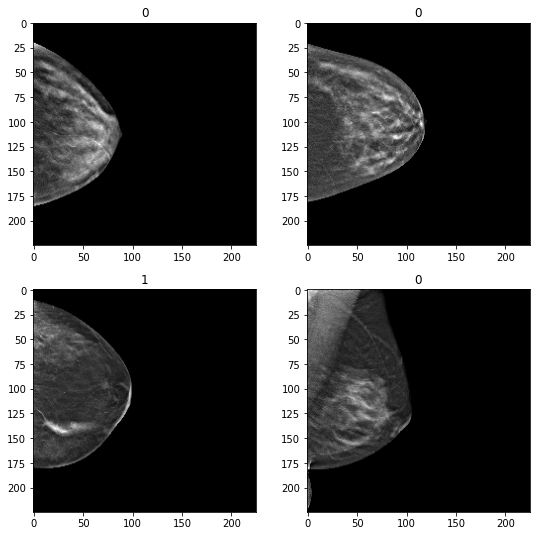

In [99]:
fig,axis = plt.subplots(2,2,figsize = (9,9))

for i in range(2):
  for j in range(2):
    random_index = np.random.randint(0,file_num)
    img, label = train_dataset[random_index]
    axis[i][j].imshow(img[0], cmap = "gray")
    axis[i][j].set_title(label)

In [100]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [101]:
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([2280,  900]))

# Model creation

##ResNet50

In [102]:
# torchvision.models.resnet50();

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [104]:
import torchmetrics

class CheastCancer_ResNet(pl.LightningModule):

  def __init__(self,init_weights=True):
    super().__init__()

    self.model = torchvision.models.resnet50()
    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)

    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)

    #loss function
    self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))

    #eval matrix
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    #list to store loss curve and accuracy curve
    self.traincc, self.valacc = [],[]
    self.trainloss, self.valloss = [],[0]

  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    img, label = batch
    pred = self(img)
    # label = label.float()
    loss = self.criterion(pred[:,0],label.float())
    acc = self.train_acc(pred[:,0],label)

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred[:,0]), label.int()))

    return loss
  
  def training_epoch_end(self, outs):
    self.log("Train ACC", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    img, label = batch
    # label = label.float()
    pred = self(img)
    # loss = self.loss_fn(pred,label)
    loss = self.criterion(pred[:,0],label.float())

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.val_acc(torch.sigmoid(pred[:,0]), label.int()))

  
  def validation_epoch_end(self, outs):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
      return [self.optimizer]

### Training

In [105]:
model = CheastCancer_ResNet()

In [106]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Project/checkpoint/ResNet",
    filename="sample-breastcancer-{epoch:02d}-{Val ACC:.2f}",
    monitor = "Val ACC",
    save_top_k = 10,
    mode ="max")

In [107]:
gpus = 1
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/drive/MyDrive/Project/logs/ResNet"), log_every_n_steps = 1,
                     callbacks = checkpoint_callback, max_epochs = 30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [108]:
trainer.fit(model, train_loader, val_loader)

Missing logger folder: /content/drive/MyDrive/Project/logs/ResNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 23.5 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.015    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Evaluation

In [110]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = CheastCancer_ResNet.load_from_checkpoint("/content/drive/MyDrive/Project/checkpoint/ResNet/sample-breastcancer-epoch=14-Val ACC=0.49.ckpt")
# model.eval()

# preds = []
# labels = []

# with torch.no_grad():
#   correct = 0
#   for data, label in tqdm(val_dataset):
#     data = data.float().unsqueeze(0)
#     pred = torch.sigmoid(model(data)[0])
#     preds.append(pred)
#     labels.append(label)

# preds = torch.tensor(preds)
# labels = torch.tensor(labels).int()

# acc = torchmetrics.Accuracy()(preds,labels)
# precision = torchmetrics.Precision()(preds,labels)
# recall = torchmetrics.Recall()(preds,labels)
# cm = torchmetrics.ConfusionMatrix(num_classes = 2)(preds,labels)/477

# print(f"Val Accuracy:{acc}")
# print(f"Val Precision:{precision}")
# print(f"Val Recall:{recall}")
# print(f"Confusion Matrix:{cm}")

## VGG

### Model

In [111]:
# torchvision.models.vgg19();

In [112]:
class CheastCancer_VGG(pl.LightningModule):

  def __init__(self,init_weights=True):
    super().__init__()

    self.model = torchvision.models.vgg19()
    self.model.features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    self.model.classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features=25088, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=4096, out_features=4096, bias=True),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(p=0.5, inplace=False),
        torch.nn.Linear(in_features=4096, out_features=1, bias=True)  
      )
    
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-3)

    #loss function
    self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))

    #eval matrix
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()

    #list to store loss curve and accuracy curve
    self.traincc, self.valacc = [],[]
    self.trainloss, self.valloss = [],[0]

  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    img, label = batch
    pred = self(img)
    # label = label.float()
    loss = self.criterion(pred[:,0],label.float())
    acc = self.train_acc(pred[:,0],label)

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred[:,0]), label.int()))

    return loss
  
  def training_epoch_end(self, outs):
    self.log("Train ACC", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    img, label = batch
    # label = label.float()
    pred = self(img)
    # loss = self.loss_fn(pred,label)
    loss = self.criterion(pred[:,0],label.float())

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.val_acc(torch.sigmoid(pred[:,0]), label.int()))

    return loss
  
  def validation_epoch_end(self, outs):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
      return [self.optimizer]

### Training

In [113]:
model2 = CheastCancer_VGG()

In [114]:
checkpoint_callback2 = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Project/checkpoint/VGG",
    filename="sample-breastcancer-{epoch:02d}-{Val ACC:.2f}",
    monitor = "Val ACC",
    save_top_k = 10,
    mode ="max")

In [115]:
gpus = 1
trainer2 = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/drive/MyDrive/Project/logs/VGG"), log_every_n_steps = 1,
                     callbacks = checkpoint_callback2, max_epochs = 30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [116]:
trainer2.fit(model2, train_loader, val_loader)

Missing logger folder: /content/drive/MyDrive/Project/logs/VGG/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | VGG               | 134 M 
1 | criterion | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
539.414   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

###Evaluation

In [117]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = CheastCancer_VGG.load_from_checkpoint("/content/drive/MyDrive/Project/checkpoint/VGG/sample-breastcancer-epoch=00-Val ACC=0.29.ckpt")
# model.eval()

# preds = []
# labels = []

# with torch.no_grad():
#   correct = 0
#   for data, label in tqdm(val_dataset):
#     data = data.float().unsqueeze(0)
#     pred = torch.sigmoid(model(data)[0])
#     preds.append(pred)
#     labels.append(label)

# preds = torch.tensor(preds)
# labels = torch.tensor(labels).int()

# acc = torchmetrics.Accuracy()(preds,labels)
# precision = torchmetrics.Precision()(preds,labels)
# recall = torchmetrics.Recall()(preds,labels)
# cm = torchmetrics.ConfusionMatrix(num_classes = 2)(preds,labels)/477

# print(f"Val Accuracy:{acc}")
# print(f"Val Precision:{precision}")
# print(f"Val Recall:{recall}")
# print(f"Confusion Matrix:{cm}")

## ConvNet

### Model

In [118]:
from torchvision.models.googlenet import BasicConv2d
model = torchvision.models.inception_v3()
model.AuxLogits.fc

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Linear(in_features=768, out_features=1000, bias=True)

In [119]:
import torchmetrics

class CheastCancer_ConvNet(pl.LightningModule):

  def __init__(self,init_weights=True):
    super().__init__()

    self.model = torchvision.models.inception_v3()
    self.model.Conv2d_1a_3x3 = BasicConv2d(1, 32, kernel_size=3, stride=1)
    # self.model.Mixed_5b.branch5x5_2 = BasicConv2d(48, 64, kernel_size=3, padding=1)
    self.model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
    model.AuxLogits.fc = torch.nn.Linear(in_features=768, out_features=1, bias=True)
    
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-3)

    #loss function
    self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))

    #eval matrix
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()


  def forward(self, data):
    pred = self.model(data)
    return pred

  def training_step(self, batch, batch_idx):
    img, label = batch
    pred = self(img)
    # label = label.float()
    loss = self.criterion(pred.logits,label.float().unsqueeze(1))

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred.logits), label.int().unsqueeze(1)))

    return loss
  
  def training_epoch_end(self, outs):
    self.log("Train ACC", self.train_acc.compute())

  def validation_step(self, batch, batch_idx):
    img, label = batch
    # label = label.float()
    pred = self(img)
    # loss = self.loss_fn(pred,label)
    if isinstance(pred, tuple):
      loss = self.criterion(pred.logits,label.float().unsqueeze(1))
    else:
      loss = self.criterion(pred,label.float().unsqueeze(1))

    self.log("Train Loss", loss)
    self.log("Step Train ACC", self.val_acc(torch.sigmoid(pred), label.int().unsqueeze(1)))

    return loss
  
  def validation_epoch_end(self, outs):
    self.log("Val ACC", self.val_acc.compute())

  def configure_optimizers(self):
      return [self.optimizer]

In [120]:
#model 3

model3 = CheastCancer_ConvNet()

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [121]:
checkpoint_callback3 = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Project/checkpoint/ConvNet",
    filename="sample-breastcancer-{epoch:02d}-{Val ACC:.2f}",
    monitor = "Val ACC",
    save_top_k = 10,
    mode ="max")

In [122]:
gpus = 1
trainer3 = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/drive/MyDrive/Project/logs/ConvNet"), log_every_n_steps = 1,
                     callbacks = checkpoint_callback3, max_epochs = 30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer3.fit(model3, train_loader, val_loader)

Missing logger folder: /content/drive/MyDrive/Project/logs/ConvNet/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | Inception3        | 25.1 M
1 | criterion | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.455   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = CheastCancer_ConvNet.load_from_checkpoint("/content/drive/MyDrive/Project/checkpoint/ConvNet/sample-breastcancer-epoch=13-Val ACC=0.22.ckpt")
# model.eval()

# preds = []
# labels = []

# with torch.no_grad():
#   correct = 0
#   for data, label in tqdm(val_dataset):
#     data = data.float().unsqueeze(0)
#     pred = torch.sigmoid(model(data)[0])
#     preds.append(pred)
#     labels.append(label)

# preds = torch.tensor(preds)
# labels = torch.tensor(labels).int()

# acc = torchmetrics.Accuracy()(preds,labels)
# precision = torchmetrics.Precision()(preds,labels)
# recall = torchmetrics.Recall()(preds,labels)
# cm = torchmetrics.ConfusionMatrix(num_classes = 2)(preds,labels)/477

# print(f"Val Accuracy:{acc}")
# print(f"Val Precision:{precision}")
# print(f"Val Recall:{recall}")
# print(f"Confusion Matrix:{cm}")